<a href="https://colab.research.google.com/github/nosgueira/PLN-2022-1/blob/main/PLN_W2V_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Classification Using Word2Vec 

In [ ]:
!pip install -qU gensim

## Imports

In [ ]:
from nltk.tokenize import TweetTokenizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical
from gensim.models import KeyedVectors
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
import gensim.downloader



from scipy.sparse import hstack
from scipy.sparse import vstack
from scipy.stats import loguniform
import nltk
import pandas as pd
import numpy as np

import re

nltk.download('punkt')
nltk.download('stopwords')



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

##  Data processing

### Loading data

In [ ]:
corpus = pd.read_csv('https://query.data.world/s/aikveq4giwygvkn4wyirtwiqwmyc7q')

In [ ]:
corpus

,Unnamed: 0,tweet_category,user,location,date,text
0,0,1,dflenick,"Davie, FL",2020-02-11 20:03:56,b'RT @TribulationThe: Deep State Dems continue...
1,1,1,RestartMIGA6,NaN,2020-02-11 20:03:54,b'RT @restartleader: The Republicans of Americ...
2,2,1,RayeannJ,"California, USA",2020-02-11 20:03:54,b'RT @DeeTwoCents: This is the Republican\xe2\...
3,3,1,peggydumptrump,United States,2020-02-11 20:03:53,"b""RT @mog7546: \xe2\x80\x9cSOFT ON CRIME\xe2\x..."
4,4,1,LochnerWalter,NaN,2020-02-11 20:03:52,b'RT @AndyOstroy: @realDonaldTrump YOU\xe2\x80...
...,...,...,...,...,...,...
209872,104932,0,CrypticIcon,NaN,2020-03-07 04:51:48,RT @Jim_Jordan: The Comey FBI lied to the FISA...
209873,104933,0,SwordofTruth10,NaN,2020-03-07 08:30:30,RT @DiamondandSilk: Ex-Treasury Employee Plead...
209874,104934,0,thegre8_1,USA,2020-03-07 04:27:53,RT @DailyMail: US hospitals are preparing for ...
209875,104935,0,billslater,"Chicago, IL",2020-03-07 04:55:39,RT @RealJamesWoods: MY NAME IS BILL W. I like...


Por questões de economia de tempo, serão utilizados apenas 25% dos tweets:

In [ ]:
corpus = corpus.groupby('tweet_category', group_keys=False).apply(lambda x:x.sample(frac=0.25, random_state=42))


In [ ]:
corpus['tweet_category'].value_counts()

1    26235
0    26234
Name: tweet_category, dtype: int64

### Spliting the data

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [ ]:
X = corpus.text
y = corpus.tweet_category
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.2, random_state=42)

In [ ]:
y_train.value_counts()

0    16851
1    16729
Name: tweet_category, dtype: int64

In [ ]:
y_valid.value_counts()

1    4243
0    4152
Name: tweet_category, dtype: int64

In [ ]:
y_test.value_counts()

1    5263
0    5231
Name: tweet_category, dtype: int64

### Text preprocessing

In [ ]:
NUM_WORDS=20000
tokenizer = Tokenizer(NUM_WORDS, lower=True)

In [ ]:
tokenizer.fit_on_texts(X_train.values)

In [ ]:
X_train_seq  = tokenizer.texts_to_sequences(X_train.values)
X_valid_seq  = tokenizer.texts_to_sequences(X_valid.values)
X_test_seq   = tokenizer.texts_to_sequences(X_test.values)

In [ ]:
word_index = tokenizer.word_index

In [ ]:
X_train_padded = pad_sequences(X_train_seq)
X_train_padded.shape

(33580, 344)

In [ ]:
X_valid_padded = pad_sequences(X_valid_seq, maxlen=X_train_padded.shape[-1])
X_valid_padded.shape

(8395, 344)

In [ ]:
X_test_padded = pad_sequences(X_test_seq, maxlen=X_train_padded.shape[-1])
X_test_padded.shape

(10494, 344)

In [ ]:
y_train_cat = to_categorical(y_train)
y_valid_cat = to_categorical(y_valid)
y_test_cat = to_categorical(y_test)

## Feature Extraction

### Vectorization with Word2Vec 

In [ ]:
tknzr = TweetTokenizer(strip_handles=True, reduce_len=True, preserve_case=False)
tokenized_texts = [ tknzr.tokenize(tweet) for tweet in X_train.values]

In [ ]:
from gensim.models.word2vec import Word2Vec
model = Word2Vec(sentences=tokenized_texts,vector_size=100)

In [ ]:
wv=model.wv

In [ ]:
EMBEDDING_DIM = 100
vocab_size=min(len(word_index)+1, NUM_WORDS)


In [ ]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
    if i>=NUM_WORDS:
        continue
    try :
        embedding_vector = wv[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i] = np.random.normal(0, np.sqrt(0.25), EMBEDDING_DIM)

In [ ]:
del(wv)

## Training Models

### Convolutional Neural Network

In [ ]:
from keras.models import Model
from keras import regularizers
from keras.layers import Embedding, Input, Reshape
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import concatenate, Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam


Hyper-paramters:

In [ ]:
NUM_FILTERS = 100

In [ ]:
seq_len = X_train_padded.shape[1]
seq_len

344

In [ ]:
embedding_layer = Embedding(vocab_size,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            trainable=False)

In [ ]:
inputs = Input(shape=(seq_len,))
embedding = embedding_layer (inputs)
reshape = Reshape((seq_len, EMBEDDING_DIM, 1)) (embedding)


conv_0 = Conv2D(NUM_FILTERS, (3, EMBEDDING_DIM),activation='relu', kernel_regularizer=regularizers.l2(0.01))(reshape)
conv_1 = Conv2D(NUM_FILTERS, (4, EMBEDDING_DIM),activation='relu', kernel_regularizer=regularizers.l2(0.01))(reshape)
conv_2 = Conv2D(NUM_FILTERS, (5, EMBEDDING_DIM),activation='relu', kernel_regularizer=regularizers.l2(0.01))(reshape)

maxpool_0 = MaxPooling2D((seq_len - 4, 1), strides=(1,1))(conv_0)
maxpool_1 = MaxPooling2D((seq_len - 5, 1), strides=(1,1))(conv_1)
maxpool_2 = MaxPooling2D((seq_len - 6, 1), strides=(1,1))(conv_2)

merged_tensor = concatenate([maxpool_0, maxpool_1, maxpool_2], axis=1)
flatten = Flatten()(merged_tensor)
dropout = Dropout(0.5)(flatten)
output = Dense(units=2, activation='softmax', kernel_regularizer=regularizers.l2(0.01)) (dropout)


In [ ]:
model = Model(inputs, output)

In [ ]:
adam = Adam(learning_rate=1e-3)

model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['acc'])

callbacks = [EarlyStopping(monitor='val_loss',patience=2)]

In [ ]:
model.fit(X_train_padded,y_train_cat,
          validation_data=(X_valid_padded, y_valid_cat),
          batch_size=1000,
          epochs=10, 
          callbacks=callbacks )

Epoch 1/10
34/34 [==============================] - 145s 4s/step - loss: 0.2304 - acc: 0.9448 - val_loss: 0.1508 - val_acc: 0.9799
Epoch 2/10
34/34 [==============================] - 145s 4s/step - loss: 0.1313 - acc: 0.9820 - val_loss: 0.1089 - val_acc: 0.9832
Epoch 3/10
34/34 [==============================] - 144s 4s/step - loss: 0.1021 - acc: 0.9853 - val_loss: 0.0911 - val_acc: 0.9853
Epoch 4/10
34/34 [==============================] - 144s 4s/step - loss: 0.0889 - acc: 0.9864 - val_loss: 0.0816 - val_acc: 0.9858
Epoch 5/10
34/34 [==============================] - 145s 4s/step - loss: 0.0802 - acc: 0.9874 - val_loss: 0.0747 - val_acc: 0.9863
Epoch 6/10
34/34 [==============================] - 145s 4s/step - loss: 0.0757 - acc: 0.9870 - val_loss: 0.0712 - val_acc: 0.9876
Epoch 7/10
34/34 [==============================] - 144s 4s/step - loss: 0.0709 - acc: 0.9879 - val_loss: 0.0680 - val_acc: 0.9870
Epoch 8/10
34/34 [==============================] - 145s 4s/step - loss: 0.0683 - a

In [ ]:
y_prob = model.predict(X_test_padded)

In [ ]:
y_pred = np.argmax(y_prob, axis=1)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      5231
           1       0.99      0.98      0.99      5263

    accuracy                           0.99     10494
   macro avg       0.99      0.99      0.99     10494
weighted avg       0.99      0.99      0.99     10494



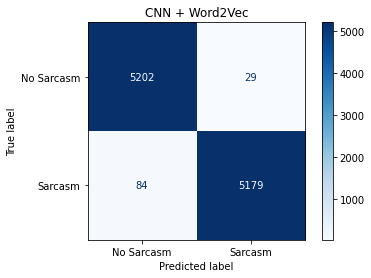

In [ ]:
cm=confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Sarcasm", "Sarcasm"])
disp.plot(cmap=plt.cm.Blues)
disp.ax_.set_title("CNN + Word2Vec")
plt.show()